In [11]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [21]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip /content/hymenoptera_data.zip

Archive:  /content/hymenoptera_data/test_data.zip
replace test_data/dog5.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test_data/dog5.jpg      
  inflating: __MACOSX/test_data/._dog5.jpg  
  inflating: test_data/bee4.jpeg     
  inflating: __MACOSX/test_data/._bee4.jpeg  
  inflating: test_data/dog4.jpg      
  inflating: __MACOSX/test_data/._dog4.jpg  
  inflating: test_data/dog3.jpg      
  inflating: __MACOSX/test_data/._dog3.jpg  
  inflating: test_data/dog6.jpeg     
  inflating: __MACOSX/test_data/._dog6.jpeg  
  inflating: test_data/dog2.jpg      
  inflating: __MACOSX/test_data/._dog2.jpg  
  inflating: test_data/dog1.jpg      
  inflating: __MACOSX/test_data/._dog1.jpg  
  inflating: test_data/cat1.jpg      
  inflating: __MACOSX/test_data/._cat1.jpg  
  inflating: test_data/cat2.jpg      
  inflating: __MACOSX/test_data/._cat2.jpg  
  inflating: test_data/cat3.jpg      
  inflating: __MACOSX/test_data/._cat3.jpg  
  inflating: test_data/bee2.jpg      
  inflating:

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

for inputs, labels in dataloaders['train']:
  print(labels)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# print(dataset_sizes)

class_names = image_datasets['train'].classes
# print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor([3, 0, 2, 0])
tensor([2, 0, 0, 3])
tensor([3, 0, 0, 0])
tensor([0, 1, 3, 0])
tensor([3, 1, 2, 3])
tensor([3, 2, 3, 1])
tensor([3, 3, 1, 0])
tensor([0, 2, 0, 1])
tensor([0, 0, 1, 3])
tensor([1, 1, 3, 2])
tensor([1, 3, 0, 3])
tensor([3, 2, 3, 1])
tensor([0, 2, 0, 2])
tensor([0, 3, 0, 2])
tensor([1, 3, 0, 1])
tensor([2, 1, 1, 0])
tensor([2, 1, 3, 2])
tensor([1, 2, 3, 2])
tensor([3, 2, 0, 1])
tensor([3, 0, 3, 1])
tensor([2, 3, 2, 3])
tensor([2, 3, 3, 0])
tensor([3, 2, 2, 0])
tensor([3, 3, 1, 3])
tensor([3, 3, 2, 1])
tensor([2, 1, 2, 3])
tensor([0, 1, 3, 1])
tensor([3, 2, 0, 0])
tensor([0, 3, 3, 0])
tensor([2, 3, 3, 3])
tensor([3, 2, 1, 3])
tensor([0, 1, 0, 2])
tensor([3, 0, 3, 0])
tensor([2, 3, 3, 0])
tensor([1, 3, 0, 1])
tensor([3, 3, 1, 2])
tensor([2, 2, 0, 0])
tensor([3, 1, 2, 2])
tensor([0, 1, 1, 0])
tensor([1, 2, 0, 1])
tensor([1, 0, 0, 0])
tensor([1, 2, 1, 1])
tensor([2, 2, 1, 2])
tensor([2, 0, 0, 1])
tensor([2, 3, 2, 3])
tensor([1, 1, 0, 0])
tensor([3, 2, 1, 2])
tensor([2, 3,

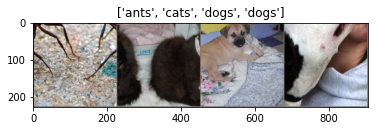

torch.Size([4, 3, 224, 224])


In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print(inputs.shape)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

[link text](https://)**Change the pre_trained model here!!!**

1.   List item
2.   List item



In [16]:
# https://pytorch.org/docs/stable/torchvision/models.html
model_name ="resnet"

In [17]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Epoch 0/49
----------
train Loss: 0.7611 Acc: 0.6786
val Loss: 0.2447 Acc: 0.9142

Epoch 1/49
----------
train Loss: 0.8151 Acc: 0.7206
val Loss: 0.3588 Acc: 0.8798

Epoch 2/49
----------
train Loss: 0.8168 Acc: 0.7126
val Loss: 0.6230 Acc: 0.8197

Epoch 3/49
----------
train Loss: 0.7670 Acc: 0.7265
val Loss: 0.2492 Acc: 0.9056

Epoch 4/49
----------
train Loss: 0.6326 Acc: 0.7605
val Loss: 0.3456 Acc: 0.8927

Epoch 5/49
----------
train Loss: 0.6152 Acc: 0.7804
val Loss: 0.5341 Acc: 0.8498

Epoch 6/49
----------
train Loss: 0.6433 Acc: 0.7665
val Loss: 0.4114 Acc: 0.8712

Epoch 7/49
----------
train Loss: 0.4746 Acc: 0.8263
val Loss: 0.2939 Acc: 0.9099

Epoch 8/49
----------
train Loss: 0.4310 Acc: 0.8463
val Loss: 0.2617 Acc: 0.9227

Epoch 9/49
----------
train Loss: 0.4378 Acc: 0.8463
val Loss: 0.1925 Acc: 0.9399

Epoch 10/49
----------
train Loss: 0.4029 Acc: 0.8463
val Loss: 0.2561 Acc: 0.9099

Epoch 11/49
----------
train Loss: 0.3779 Acc: 0.8503
val Loss: 0.2278 Acc: 0.9399

Ep

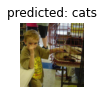

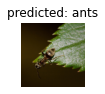

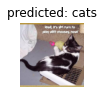

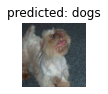

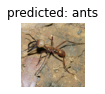

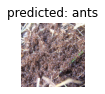

In [70]:
model_ft, input_size = initialize_model(model_name, len(class_names), feature_extract = False, use_pretrained = True)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9) # Stochastic gradient descent

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)
visualize_model(model_ft)

In [71]:
# Upload file csv for writing
from google.colab import files
uploaded = files.upload()

In [73]:
data_dir_test = '/content/hymenoptera_data/test/'
# data_dir_test: directory path to the test images file (the file we need to evaluate)
from PIL import Image
from torch.autograd import Variable
import os

image_path = []
for img in os.listdir(data_dir_test):
    image_path.append(img)

test_transforms = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),])
def predict_image(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)

    index = output.data.cpu().numpy().argmax()
    return class_names[index]

    for key, value in new_dict.items():
        file.write("{},{}\n".format(key, value))

import csv
import pandas as pd

# Change the path to csv file here
with open('/content/ans.csv', 'w+') as f:
    f.write('filename,category\n')
    for image in image_path:
      ans = predict_image(Image.open(data_dir_test+image),model_ft)
      f.write("{},{}\n".format(image, ans))

In [75]:
result_df = pd.read_csv('/content/ans.csv')
result_df

,filename,category
0,ant1.jpeg,ants
1,ant2.jpg,ants
2,ant3.webp,ants
3,ant4.jpg,ants
4,bee1.jpg,bees
5,bee2.jpg,bees
6,bee3.jpg,bees
7,bee4.jpeg,cats
8,cat1.jpg,cats
9,cat2.jpg,cats


In [ ]:
# model_conv = torchvision.models.resnet18(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as
# # opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)

In [ ]:
# visualize_model(model_conv)

# plt.ioff()
# plt.show()